<a href="https://colab.research.google.com/github/dmosh/deeplearning/blob/main/imageclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing the neccessary libraries
import glob
import cv2 as cv
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import random
import os
import requests
import urllib
from io import BytesIO
import PIL
import pathlib
import splitfolders
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from google.colab import drive
#!pip install split-folders

In [2]:
#mount drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#load and read the images
url = "/content/drive/MyDrive/Colab Notebooks/deeplearning/dataset1/known_images"
image_dir = pathlib.Path(url)

image_dir

PosixPath('/content/drive/MyDrive/Colab Notebooks/deeplearning/dataset1/known_images')

In [4]:
splitfolders.ratio(image_dir, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 715 files [00:07, 100.40 files/s]


In [5]:
normal = [fn for fn in os.listdir(f'{image_dir}/normal') if fn.endswith('.png')]
sick = [fn for fn in os.listdir(f'{image_dir}/sick') if fn.endswith('.png')]

image = [normal, sick]
image_class = []

for i in os.listdir('imgs/train'):
  image_class+=[i]
image_class.sort()

In [6]:
image_count = len(list(image_dir.glob('*/*.png')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(image_class)}')
count = 0
rice_count = []
for x in image_class:
  print(f'Total {x} images: {len(image[count])}')
  rice_count.append(len(image[count]))
  count += 1


Total images: 715
Total number of classes: 2
Total normal images: 364
Total sick images: 351


Image dimensions: (488, 395, 3)


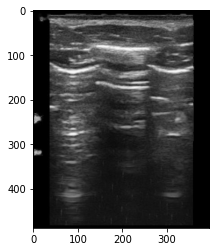

In [7]:
sample_img = cv.imread('/content/imgs/test/normal/normal_0.png')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [8]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in image_class:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

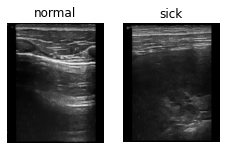

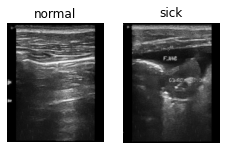

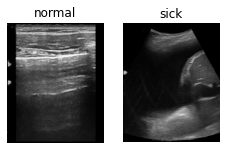

In [10]:
for i in range(3):
  load_random_img(image_dir, image_class)

image preprocessing

In [9]:
batch_size = 128
img_height, img_width = 480, 390
input_shape = (img_height, img_width, 3)

In [10]:
datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 499 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


In [12]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

CNN Model

In [13]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [15]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 478, 388, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 478, 388, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 478, 388, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 478, 388, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 239, 194, 32)     0         
 )                                                               
                                                        

In [16]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/cnn_model.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
history1 = cnn_model.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

Epoch 1/40
